# Practicum II: working with IMDB datasets
Audrey Jo, Hasti Dehnashi, Thinh Lam

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

**Modules**

In [1]:
import pandas
from numpy import nan
import cryptography
import getpass
import pymysql
pymysql.install_as_MySQLdb() # used to run MySQLdb and sqlalchemy
from sqlalchemy import create_engine
import mysql.connector
from mysql.connector import Error
import re

## Required User Inputs

**MySQL**
password for root user

In [2]:
password = getpass.getpass(prompt='MySQL root user password: ', stream=None)

MySQL root user password: ········


**TSV** file paths

In [3]:
path = "C:/Users/Mr.Lam/Desktop/CS5200/Practicum II"

title_tsv = path + "/title.basics.tsv"
alias_tsv = path + "/title.akas.tsv"
principal_tsv = path + "/title.principals.tsv"
rating_tsv = path + "/title.rating.tsv"
episode_tsv = path + "/title.episode.tsv"
crew_tsv = path + "/title.crew.tsv"
name_tsv = path + "/name.basics.tsv"


**Functions**

In [4]:
def execute_sql_script(sql_file):
    '''
    Reads and executes SQL statements from a .sql file
    '''
    statement = ""
    for line in open(sql_file):
        if re.match(r'--', line):  # ignore sql comment lines
            continue
        if not re.search(r';$', line):  # keep appending lines that don't end in ';'
            statement = statement + line
        else:  # when you get a line ending in ';' then exec statement and reset for next statement
            statement = statement + line
            engine.execute(statement)
            statement = ""
            
def extract_table(table, column_to_extract, new_table_id):
    '''
        Extracts a column with comma-separated values
        as a new table.
        
        table: data frame containing the column to be
        extracted
        
        column_to_extract: name of the column in the
        table that will be extracted
        
        new_table_id: name of the primary key column for
        the new table created from the extracted column
    '''
    
    # Extract the column from the table
    extracted = table[column_to_extract]
    
    # Split the column into multiple columns by splitting on comma (creates a data frame)
    # https://stackoverflow.com/a/46856366
    extracted = extracted.str.split(',', expand=True)

    # Generate a list of unique values for all values in the extracted data frame
    # https://www.kite.com/python/answers/how-to-find-the-unique-values-in-multiple-columns-of-a-pandas-dataframe-in-python
    extracted_unique = pandas.unique(extracted.values.ravel())
    
    # Exclude missing values in the list of unique values for the extracted table
    extracted_unique = [i for i in extracted_unique if i not in [nan, None]]

    # Create a data frame using the unique values for the extracted table
    #   create a dictionary with a unique ID field and description field 
    #   for the extracted table
    data = {new_table_id: list(range(1, len(extracted_unique) + 1)), 
            "description": extracted_unique}
    new_table = pandas.DataFrame(data)
    
    # Replace format with formatId in Title table
    #    create dictionary for replacing format with formatId
    data = new_table.to_dict('list')
    formats = {} # format: {format: formatId}
    for i, f in zip(data[new_table_id], data['description']):
        formats[f] = i
    
    #    replace format with formatId in Title table
    table[column_to_extract] = table[column_to_extract].replace(to_replace=formats)
    return table, new_table

def junction_table(table, table_id, column_to_extract, new_table_id, new_junction_id):
    '''
        Extracts a column with comma-separated values
        as a new table. Then, it creates a junction
        table between the table and the new table.
        
        table: data frame containing the column to be
        extracted
        
        table_id: name of the primary key column for
        the table
        
        column_to_extract: name of the column in the
        table that will be extracted
        
        new_table_id: name of the primary key column for
        the new table created from the extracted column
        
        new_junction_id: name of the primary key
        column for the junction table created from
        the extracted column
    '''
    
    # Extract the column from the table
    extracted = table[column_to_extract]
    
    # Split the column into multiple columns by splitting on comma (creates a data frame)
    # https://stackoverflow.com/a/46856366
    extracted = table[column_to_extract].str.split(',', expand=True)
    
    # Generate a list of unique values for all values in the extracted data frame
    # https://www.kite.com/python/answers/how-to-find-the-unique-values-in-multiple-columns-of-a-pandas-dataframe-in-python
    extracted_unique = pandas.unique(extracted.values.ravel())
    
    # Exclude missing values in the list of unique values for the extracted table
    extracted_unique = [i for i in extracted_unique if i not in [nan, None]]

    # Create a data frame using the unique values for the extracted table
    #   create a dictionary with a unique ID field and description field 
    #   for the extracted table
    data = {new_table_id: list(range(1, len(extracted_unique) + 1)),
            "description": extracted_unique}
    new_table = pandas.DataFrame(data)
    
    # Replace description with new_table_id in Title table
    #    create dictionary for replacing description with new_table_id
    data = new_table.to_dict('list')
    formats = {} # format: {description: new_table_id}
    for i, f in zip(data[new_table_id], data['description']):
        formats[f] = i
    
    #    replace description with new_table_id in Title table
    table[column_to_extract] = table[column_to_extract].replace(to_replace=formats)
    
    # Get a list of extracted columns excluding the 1st column
    cols = list(extracted)
    cols = cols[1:]
    
    # Extract the column from the table to create a new table
    table, new_table = extract_table(table, column_to_extract, new_table_id)
    
    # Add the primary key from table to the extracted data frame
    extracted[table_id] = title_df[table_id]
    
    # Rename 1st extracted column to new_table_id
    junction = extracted.rename(columns={0: new_table_id})

    # Create a table out of the table_id and the 1st extracted column
    junction = junction[[table_id, new_table_id]]
    
    # Drop rows with missing values
    junction = junction.dropna(axis=0, how='any')

    # Create a uniqueID for the junction table
    junction = junction.reset_index(drop=True)
    junction[new_junction_id] = junction.index + 1
    
    # for each additional extracted column (column extracted from table and 
    #    expanded into multiple columns),
    for col in cols:
        subset = extracted[[table_id, col]] # grab nth set of table_id and new_table_id
        subset = subset.rename(columns={col: new_table_id}) # rename extracted column to new_table_id
        subset = subset.dropna(axis=0, how='any') # drop rows with missing values
        subset = subset.reset_index(drop=True) # reset the index to reflect reduced number of rows
        subset[new_junction_id] = subset.index + len(junction) + 1 # make sure new_junction_id is unique
        junction = junction.append(subset, ignore_index=True) # actually append the subset data frame

    # Create a dictionary to replace description with new_table_id in junction table
    data = new_table.to_dict('list')
    genres = {} # format: {genre: genreId}
    for i, t in zip(data[new_table_id], data['description']):
        genres[t] = i

    # Replace description with new_table_id in junction table
    junction = junction.replace(to_replace=genres)

    # Reorder columns
    junction = junction[[new_junction_id, table_id, new_table_id]]
    
    return table, new_table, junction

## Step 2. ERD Diagrams
### A. 1st ERD
In this ER diagram, we have one table per tsv file from IMDB. Our understanding was that we are creating an ER diagram for understanding the relationships between the tsv files prior to normalizing them by adding association and junction tables. A title (title.basics.tsv) has many alias titles (title.akas.tsv) since a single title has many translated versions in the akas table. A title can have 0 or 1 rating since the rating table stores an average of ratings. A title can have 0 or many episodes. A title can have 0 or 1 crew, but 0 to many principal characters. Every nconst in principal table must exist in the name table, but not every name in the name table must appear in the principal table. Also, a name could appear as a principal in multiple titles, in which case a name would have many principals. 
![image](files/erd_2a.png)
### B. 2nd ERD
Here, we have the basic relationships between the tables preserved from the 1st ERD, but we denormalized the original tables by adding association/junction tables for multi-valued columns. Title (title.basics) table originally had genres, a multi-valued column. We created Genre table using unique values from the genres column. Then, added TitleGenre which contains the primary keys from both Title and Genre tables. The titleFormat column was pulled out into a separate table as well to make it so that a user would not be able to add random strings and would be limited to the lookup table called Format, but an admin would be able to add new formats by adding another row. 

Alias title table (title.akas) had two multi-valued columns, types and attributes. These were pulled out into their own tables with junction tables such as AliasTitleType and AliasTitleAttribute tables which contained the primary keys for AliasTitle and Type/Attribute. 

Principal table (title.principal) had one multi-valued column, characters. This table was pulled out into PrincipalCharacters, which had the primary key of Principal table and a single character value. So, PrincipalCharacter could have multiple records with the same principalId. We added a primary key for this table to make sure that each row can be uniquely identified.

Name table had 2 multi-valued columns, primaryProfesson and knownForTitles. For primaryProfession, the unique values were pulled out into a Profession table and a primary key professionId was added. Then, we added a junction table called NameProfession, which had the primary keys for both Name and Profession and added a primary key for this table as well because a single name can have 0 to many professions meaning there could be multiple rows with the same nconst. For knownForTitles, we created a table called knownFor, which contains nconst and tconst and serves as a junction table between title table and name table. There was no need to create a table out of unique values in the knownForTitles column since the title table already exists. Instead, we just added a relationship between the knownFor table and the title table. 

Finally, crew table (title.crew) was renamed to CrewMember and it serves as a junction table between title and name table. It contains nconst, tconst, and the role of the crew (director/writer). 
![image](files/erd_2b.png?1)
### C. 3rd ERD
In this ERD, we just added age and numTitles columns in the name table.
![image](files/erd_2c.png?1)
### D. BCNF and denormalization
Denormalizing data might be done when you need to increase the performance of your database. For example, if you know that certain queries are used frequently, then you may want to consider keeping the columns for those queries in the same table, even at the cost of denormalization to improve the query performance. It can also be helpful to have columns with calculated values that need to be derived frequently.

## Connect to MySQL

In [5]:
engine = create_engine('mysql://root:' + password + '@localhost:3306', echo=False) # connect to server

**Recreate MySQL database**

Drop mydb MySQL database if it exists.
Create mydb database.

In [8]:
engine.execute("DROP DATABASE IF EXISTS mydb")
engine.execute("CREATE DATABASE IF NOT EXISTS mydb")

**Connect to MySQL database**

In [40]:
del engine
# connect to server
engine = create_engine('mysql://root:' + password + '@localhost:3306/mydb', echo=False)

### Create tables in MySQL database

In [9]:
execute_sql_script(sql_file)

## Load data into MySQL database

### title.basics.tsv
#### Load tsv file

In [10]:
title_df = pandas.read_csv(title_tsv, sep="\t", na_values="\\N")

/Users/audrey/RStudioProjects/movies/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


**Anomalies**

isAdult column is supposed to be boolean, but has values larger than 1 because 9 rows in the Title table were processed incorrectly. This was because one of the tabs was not recognized by pandas, so all of the data were shifted by one. The cell below will unshift the values for the problematic rows.

In [9]:
# unique values in isAdult column
print("Unique values in isAdult column", list(title_df['isAdult'].unique()))

# select problematic rows
dfs = title_df[title_df['isAdult'] > 1]

# split primaryTitle column into 2 (second part is supposed to be originalTitle)
dfs2 = dfs['primaryTitle'].str.split('\t', expand=True)

# shift each column down
dfs['primaryTitle'] = dfs2[0]
dfs['runtimeMinutes'] = dfs['endYear']
dfs['endYear'] = dfs['startYear']
dfs['startYear'] = dfs['isAdult']
dfs['isAdult'] = 0
dfs['originalTitle'] = dfs2[1]
print("Fixed version")
display(dfs)

# update Title table with fixed values
title_df[title_df['isAdult'] > 1] = dfs.values
print("Confirm the fix was applied to the Title table")
display(title_df.iloc[list(dfs.index),:])

Unique values in isAdult column [0, 1, 2019, 1981, 2020, 2017, 2014, 2005]


C:\Users\Mr.Lam\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mr.Lam\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Mr.Lam\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Fixed version


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
1101800,tt10233364,tvEpisode,Rolling in the Deep Dish,Rolling in the Deep Dish,0,2019,NaN,NaN,NaN
1523518,tt10970874,tvEpisode,Die Bauhaus-Stadt Tel Aviv - Vorbild für die M...,Die Bauhaus-Stadt Tel Aviv - Vorbild für die M...,0,2019,NaN,NaN,NaN
1922152,tt11670006,tvEpisode,...ein angenehmer Unbequemer...,...ein angenehmer Unbequemer...,0,1981,NaN,NaN,NaN
2035998,tt11868642,tvEpisode,GGN Heavyweight Championship Lungs With Mike T...,GGN Heavyweight Championship Lungs With Mike T...,0,2020,NaN,NaN,NaN
2196605,tt12149332,tvEpisode,Jeopardy! College Championship Semifinal Game 3,Jeopardy! College Championship Semifinal Game 3,0,2020,NaN,NaN,NaN
2347774,tt12415330,tvEpisode,Anthony Davis High Brow Tank,Anthony Davis High Brow Tank,0,2017,NaN,NaN,NaN
4572916,tt3984412,tvEpisode,"I'm Not Going to Come Last, I'm Just Going to ...","I'm Not Going to Come Last, I'm Just Going to ...",0,2014,NaN,NaN,NaN
7252939,tt9822816,tvEpisode,Zwischen Vertuschung und Aufklärung - Missbrau...,Zwischen Vertuschung und Aufklärung - Missbrau...,0,2019,NaN,NaN,NaN
7294060,tt9909210,tvEpisode,Politik und/oder Moral - Wie weit geht das Ver...,Politik und/oder Moral - Wie weit geht das Ver...,0,2005,NaN,NaN,NaN


Confirm the fix was applied to the Title table


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
1101800,tt10233364,tvEpisode,Rolling in the Deep Dish,Rolling in the Deep Dish,0,2019.0,NaN,NaN,NaN
1523518,tt10970874,tvEpisode,Die Bauhaus-Stadt Tel Aviv - Vorbild für die M...,Die Bauhaus-Stadt Tel Aviv - Vorbild für die M...,0,2019.0,NaN,NaN,NaN
1922152,tt11670006,tvEpisode,...ein angenehmer Unbequemer...,...ein angenehmer Unbequemer...,0,1981.0,NaN,NaN,NaN
2035998,tt11868642,tvEpisode,GGN Heavyweight Championship Lungs With Mike T...,GGN Heavyweight Championship Lungs With Mike T...,0,2020.0,NaN,NaN,NaN
2196605,tt12149332,tvEpisode,Jeopardy! College Championship Semifinal Game 3,Jeopardy! College Championship Semifinal Game 3,0,2020.0,NaN,NaN,NaN
2347774,tt12415330,tvEpisode,Anthony Davis High Brow Tank,Anthony Davis High Brow Tank,0,2017.0,NaN,NaN,NaN
4572916,tt3984412,tvEpisode,"I'm Not Going to Come Last, I'm Just Going to ...","I'm Not Going to Come Last, I'm Just Going to ...",0,2014.0,NaN,NaN,NaN
7252939,tt9822816,tvEpisode,Zwischen Vertuschung und Aufklärung - Missbrau...,Zwischen Vertuschung und Aufklärung - Missbrau...,0,2019.0,NaN,NaN,NaN
7294060,tt9909210,tvEpisode,Politik und/oder Moral - Wie weit geht das Ver...,Politik und/oder Moral - Wie weit geht das Ver...,0,2005.0,NaN,NaN,NaN


After the fix, some of the columns can be set to numeric data types rather than string so the below code cell updates some of the column data types.

In [10]:
title_df["isAdult"] = title_df["isAdult"].astype('Int64')

title_df["startYear"] = title_df["startYear"].fillna(0)
title_df["endYear"] = title_df["endYear"].fillna(0)

title_df["startYear"] = title_df["startYear"].astype('Int64')
title_df["endYear"] = title_df["endYear"].astype('Int64')

title_df['runtimeMinutes'] = title_df['runtimeMinutes'].fillna(-1).astype('float64')

display(title_df.head(5))


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,0,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,0,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,0,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,0,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,0,1.0,"Comedy,Short"


#### Create Format Table (from titleType column)
This is creating a format table from the titleType column in the Title table using the extract_table function.

In [12]:
title_df, format_df = extract_table(title_df, 'titleType', 'formatId')

display(format_df, title_df.head(5))

,formatId,description
0,1,short
1,2,movie
2,3,tvShort
3,4,tvMovie
4,5,tvSeries
5,6,tvEpisode
6,7,tvMiniSeries
7,8,tvSpecial
8,9,video
9,10,videoGame


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,1,Carmencita,Carmencita,0,1894,0,1.0,"Documentary,Short"
1,tt0000002,1,Le clown et ses chiens,Le clown et ses chiens,0,1892,0,5.0,"Animation,Short"
2,tt0000003,1,Pauvre Pierrot,Pauvre Pierrot,0,1892,0,4.0,"Animation,Comedy,Romance"
3,tt0000004,1,Un bon bock,Un bon bock,0,1892,0,12.0,"Animation,Short"
4,tt0000005,1,Blacksmith Scene,Blacksmith Scene,0,1893,0,1.0,"Comedy,Short"


#### Create Genre and TitleGenre Table
This is creating a Genre and TitleGenre table by using the junction_table function on genres column in Title table.

In [11]:
title_df, genre_df, title_genre_df = junction_table(title_df, 'tconst', 'genres', 
                                                    'genreId', 'titleGenreId')

display(genre_df, title_genre_df.head(5), title_df.head(5))

,genreId,description
0,1,Documentary
1,2,Short
2,3,Animation
3,4,Comedy
4,5,Romance
5,6,Sport
6,7,Action
7,8,News
8,9,Drama
9,10,Fantasy


,titleGenreId,tconst,genreId
0,1,tt0000001,1
1,2,tt0000002,3
2,3,tt0000003,3
3,4,tt0000004,3
4,5,tt0000005,4


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,0,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,0,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,0,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,0,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,0,1.0,"Comedy,Short"


#### Create Title Table
The titleType field is renamed to formatId so as to reflect the ERD in 2B/C. The genres table is dropped since the genres information has been pulled out to TitleGenre and Genre table.

In [13]:

# Rename titleType field
title_df = title_df.rename(columns={'titleType': 'formatId'})
# Drop genres field
title_df = title_df.drop(['genres'], axis=1)


title_df.head(10)

"\n# Rename titleType field\ntitle_df = title_df.rename(columns={'titleType': 'formatId'})\n# Drop genres field\ntitle_df = title_df.drop(['genres'], axis=1)\n\nprint(title_df.dtypes)\ntitle_df.head(10)\n"

#### Load data to MySQL database: Title, Format, Genre, TitleGenre (title.basics.tsv)

In [12]:
format_df.to_sql(con=engine, name='Format', if_exists='append', index=False, chunksize=1000)

genre_df.to_sql(con=engine, name='Genre', if_exists='append', index=False, chunksize=1000)

title_df.to_sql(con=engine, name='Title', if_exists='append', index=False, chunksize=1000)

title_genre_df.to_sql(con=engine, name='TitleGenre', 
                      if_exists='append', index=False, chunksize=1000)

### title.akas.tsv
#### Load tsv file
The alias title table had a composite key with ordering and tconst, but we dropped ordering column and added aliasId, which serves as the new primary key.

isOriginalTitle was converted to Int64 field.

In [14]:
#read dataset
alias_df = pandas.read_csv(alias_tsv, sep="\t", na_values="\\N")

# Drop ordering field
alias_df = alias_df.drop(['ordering'], axis=1)

# Set boolean/int fields to Int64 (allows null)
alias_df["isOriginalTitle"] = alias_df["isOriginalTitle"].fillna(-1)
alias_df["isOriginalTitle"] = alias_df["isOriginalTitle"].astype('Int64')

# Add aliasId field
cols = list(alias_df)
alias_df['aliasId'] = alias_df.index + 1
cols = ['aliasId'] + cols
alias_df = alias_df[cols]

#alias_df.head(10)

C:\Users\Mr.Lam\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Clean up data
This section handles all of the anomalies in the alias title table. The tconst column has values that exist in the alias table, but doesn't exist in the title table. Such values are getting dropped so that we don't get the foreign key constraint error in regards to the title table.

In [15]:
#Creating aliasTitle dataframe 
alias_title_df= alias_df.drop(columns = 'types')

#checking if there are bad tconst
alias_tconst = alias_title_df['titleId'].unique()
title_tconst = title_df['tconst'].unique()
alias_title_tconst_diff = list(set(alias_tconst) - set(title_tconst))
print(len(alias_title_tconst_diff))

#Check manually with title_df or title table in mySQL
print(alias_title_tconst_diff[:5])

#Removing bad tconst
alias_title_df = alias_title_df.drop(alias_title_df[alias_title_df['titleId'].isin(alias_title_tconst_diff)].index)

#double check if any bad tconst values still exist
alias_title_tconst = alias_title_df['titleId'].unique()
title_tconst = title_df['tconst'].unique()
alias_title_tconst_diff = list(set(alias_title_tconst) - set(title_tconst))
print(len(alias_title_tconst_diff))

alias_title_df.head(5)

5209
['tt1686325', 'tt1827397', 'tt1671623', 'tt3331450', 'tt4315120']
0


,aliasId,titleId,title,region,language,attributes,isOriginalTitle
0,1,tt0000001,Карменсіта,UA,NaN,NaN,0
1,2,tt0000001,Carmencita,DE,NaN,literal title,0
2,3,tt0000001,Carmencita - spanyol tánc,HU,NaN,NaN,0
3,4,tt0000001,Καρμενσίτα,GR,NaN,NaN,0
4,5,tt0000001,Карменсита,RU,NaN,NaN,0


#### Load AliasTitle to MySQL database

In [ ]:
#load to MySql
alias_title_df.to_sql(con=engine, name='AliasTitle', if_exists='append', index=False, chunksize=10000)

#### Create Type table and load to MySQL database
The unique values in the types column in the alias table is extracted to create the types table. Afterwards, the data is loaded to MySQL.


In [10]:
# Get unique values for types
types = alias_df['types'].unique().tolist() # https://stackoverflow.com/a/46856366


'''
    This is the result of alias_df['types'].unique(), which contains unwanted '\x02' subseq. 
    
    ['imdbDisplay' nan 'original' 'alternative' 'dvd' 'festival' 'working'
     'tv' 'video' 'imdbDisplay\x02tv' 'alternative\x02tv'
     'imdbDisplay\x02working' 'festival\x02imdbDisplay' 'tv\x02working'
     'imdbDisplay\x02video' 'alternative\x02dvd' 'tv\x02video'
     'dvd\x02imdbDisplay' 'alternative\x02working' 'video\x02working'
     'alternative\x02video' 'festival\x02working' 'dvd\x02video'
     'alternative\x02festival' 'dvd\x02working']
     
    These elements have been deleted in MySQL.

'''
#the original types list has a NaN value so it has to be removed
types.remove(nan)
#the original types list has a '\x02' value so it has to be removed
select = []
for i in range(len(types)):
    types[i] = types[i].replace('\x02'," ")

#check if the error in types has been fixed    
#print(types)

# Create a data frame for types
data = {"typeId": list(range(1, len(types) + 1)), "description": types}
type_df = pandas.DataFrame(data)

#load to mySQL
type_df.to_sql(con=engine, name='Type', if_exists='append', index=False, chunksize=10000)

display(type_df)

,typeId,description
0,1,imdbDisplay
1,2,original
2,3,alternative
3,4,dvd
4,5,festival
5,6,working
6,7,tv
7,8,video
8,9,imdbDisplay tv
9,10,alternative tv


#### Create ALiasTitleType table
(Note. some of these commands are shown out of order in this jupyter notebook, but they were executed in order to create the dataset we used to populate the database)
The types column in types column from alias table is used to create an AliasTitleType table which contains the primary key in alias table and the primary key in the type table.

The types column contains '\x02' which needed to be replaced with ' '.

In [25]:
#create aliasTitleType table
alias_title_type_df = alias_df.drop(columns =['title','titleId','region','language','attributes','isOriginalTitle'])

#These are extracted from types description
error = ['imdbDisplay\x02tv','alternative\x02tv','imdbDisplay\x02working', 'festival\x02imdbDisplay', 'tv\x02working',
     'imdbDisplay\x02video', 'alternative\x02dvd', 'tv\x02video',
     'dvd\x02imdbDisplay', 'alternative\x02working', 'video\x02working',
     'alternative\x02video', 'festival\x02working', 'dvd\x02video',
     'alternative\x02festival', 'dvd\x02working']

#Replacing error types 
for item in error:
    new_item = item.replace('\x02', ' ')
    alias_title_type_df.loc[alias_title_type_df['types'] == item,'types'] = new_item
    
#create dictionary to convert types desc to ID integer
typeId = list(range(1, len(types) + 1))
typeId_desc = dict(zip(typeId,types))

#convert description in 'types' to int
for k,v in typeId_desc.items():
    alias_title_type_df['types'] = alias_title_type_df['types'].replace(v,k)
    
#creating primary key for aliasTitleType table
aliasTitleTypeId = [ i for i in range(1,len(alias_title_type_df)+1)]

#insert aliasTitleTypeId to the leftmost column
alias_title_type_df.insert(0,'aliasTitleTypeId',aliasTitleTypeId)

#change name from types to typeId
alias_title_type_df = alias_title_type_df.rename(columns={'types':'typeID'})

#Find the total number of invalid alias Id
alias_title_type_aliasId = alias_title_type_df['aliasId'].unique()
alias_title_aliasId = alias_title_df['aliasId'].unique()

aliasId_diff = list(set(alias_title_type_aliasId )- set(alias_title_aliasId))
print(len(aliasId_diff))

#check if the items in alias_id_diff are error
print(aliasId_diff[0:5])

#Drop all the errors
alias_title_type_df = alias_title_type_df.drop(alias_title_type_df[alias_title_type_df['aliasId'].isin(aliasId_diff)].index)

#double check error, expected result is 0
new_ATT_aliasId = alias_title_type_df['aliasId'].unique()
new_aliasId_diff = list(set(new_ATT_aliasId)- set(alias_title_aliasId))
print(len(new_aliasId_diff))

alias_title_type_df.head(5)


imdbDisplay tv
alternative tv
imdbDisplay working
festival imdbDisplay
tv working
imdbDisplay video
alternative dvd
tv video
dvd imdbDisplay
alternative working
video working
alternative video
festival working
dvd video
alternative festival
dvd working
5230
[18022402, 17596422, 19562503, 17399819, 17924108]
0


,aliasTitleTypeId,aliasId,typeID
0,1,1,1.0
1,2,2,NaN
2,3,3,1.0
3,4,4,1.0
4,5,5,1.0


#### Load AliasTitleType to MySQL database

In [ ]:
#loading to mySQL
alias_title_type_df.to_sql(con=engine, name='AliasTitleType', if_exists='append', index=False, chunksize=10000)

#### Create Attribute Table
The attribute table was created from the attributes column in alias table. It had '\x02' which were replaced with ' '. A primary key was created for the attribute table called attributeId.

In [75]:
#creating a list of unique attribute values
attributes = alias_df['attributes'].dropna().unique()

attribute_error = []
attribute_normal = []
for item in attributes:
    if '\x02' in item:
        attribute_error.append(item)
        newitem = item.replace('\x02',' ')
        attribute_normal.append(newitem)
    else:
        attribute_normal.append(item)

print(len(attribute_normal),len(attributes))

188 188


In [76]:
#Creating primary key for attribute table
attributeId = [i for i in range(1,len(attribute_normal)+1)]

#creating attribute dataframe 
attribute_df = pandas.DataFrame()
attribute_df['attributeId'] = attributeId
attribute_df['description'] = attribute_normal

attribute_df.head(10)

,attributeId,description
0,1,literal title
1,2,literal English title
2,3,informal alternative title
3,4,promotional title
4,5,complete title
5,6,literal translation of working title
6,7,premiere title
7,8,informal title
8,9,short title
9,10,poster title


#### Load Attribute Table to MySQL database

In [42]:
#Loading to MySQL
attribute_df.to_sql(con=engine, name='Attribute', if_exists='append', index=False, chunksize=10000)

C:\Users\Mr.Lam\Anaconda3\lib\site-packages\pandas\io\sql.py:1144: UserWarning: The provided table name 'Attribute' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


#### Create AliasTitleAttribute
The attribute column contains '\x02' which were replaced with ' '. This table contains aliasId (primary key for alias table), attributeId (primary key for attribute table), and a primary key for alias title attribute table (aliasTitleAttributeId).

In [77]:
alias_title_attribute_df = alias_df.drop(columns = ['title','titleId','region','types','language','isOriginalTitle'])

for a_item in attribute_error:
    new_a_item = a_item.replace('\x02', ' ')
    print(new_a_item)
    alias_title_attribute_df.loc[alias_title_attribute_df['attributes'] == item,'attributes'] = new_item


recut version reissue title
8mm release title short version
added framing sequences and narration in Yiddish reissue title
Yiddish dubbed reissue title
POLart video box title
cut version reissue title
YIVO translation reissue title
copyright title reissue title
reissue title short version
cut version video box title
racier version reissue title
8mm release title second part title
informal title literal title
cable TV title cut version
closing credits title pre-release title
longer version rerun title
IMAX version promotional title
X-rated version bootleg title
poster title video box title
dubbed version recut version
promotional title thirteenth season title
orthographically correct title video box title
fourth season title recut version


In [78]:
attributeId_desc = dict(zip(attribute_normal,attributeId))

alias_title_attribute_df['attributes'] = alias_title_attribute_df['attributes'].map(attributeId_desc)
 


In [79]:
aliasTitleAttributeId = [i for i in range(1,len(alias_title_attribute_df)+1)]

#change attributes columns to attributeId
alias_title_attribute_df = alias_title_attribute_df.rename(columns = {'attributes':'attributeID'})

#add 'aliasTitleAttributeId' column
alias_title_attribute_df.insert(0,'aliasTitleAttributeId',aliasTitleAttributeId)

alias_title_attribute_df.head(10)

,aliasTitleAttributeId,aliasId,attributeID
0,1,1,NaN
1,2,2,1.0
2,3,3,NaN
3,4,4,NaN
4,5,5,NaN
5,6,6,NaN
6,7,7,NaN
7,8,8,NaN
8,9,9,NaN
9,10,10,NaN


In [80]:
#because I have to fill NULL value with an integer. 

alias_title_attribute_df['attributeID'] = alias_title_attribute_df['attributeID'].fillna(189).astype('Int64')
alias_title_attribute_df.head(100)

,aliasTitleAttributeId,aliasId,attributeID
0,1,1,189
1,2,2,1
2,3,3,189
3,4,4,189
4,5,5,189
5,6,6,189
6,7,7,189
7,8,8,189
8,9,9,189
9,10,10,189


In [83]:

alias_title_attribute_Id = alias_title_attribute_df['aliasId'].unique()
alias_title_Id = alias_title_df['aliasId'].unique()
aliasId_diff = list(set(alias_title_attribute_Id) - set(alias_title_Id))
print(len(d))

alias_title_attribute_df = alias_title_attribute_df.drop(alias_title_attribute_df[alias_title_attribute_df['aliasId'].isin(aliasId_diff)].index)

5230


#### Load AliasTitleAttribute table to MySQL database

In [84]:
alias_title_attribute_df.to_sql(con=engine, name='AliasTitleAttribute', if_exists='append', index=False, chunksize=10000)

C:\Users\Mr.Lam\Anaconda3\lib\site-packages\pandas\io\sql.py:1144: UserWarning: The provided table name 'AliasTitleAttribute' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


### name.basics.tsv
#### Load the data from cvs into the name df and format the data
We extracted and dropped the primaryProfession and knownForTitles column as these will be used later to create junction tables. We show here how how age and numTitles could be created, however, they were generated using update statements, see Question 5 at the end.

In [8]:
# Reading name.basic.tsv
name_df = pandas.read_csv(name_tsv, sep="\t", na_values="\\N")
   
# Seperate and extract the muulitple-values in the primaryProfession and knownForTitles columns
primary_profession = name_df['primaryProfession'].str.split(",",expand=True)
known_for_title = name_df['knownForTitles'].str.split(",",expand=True)
nameId = name_df['nconst']

# Drop the columns
Name = name_df.drop(columns="primaryProfession")
Name = Name.drop(columns='knownForTitles')

# One way to create the age and numTitles cols
# Name['age'] = Name["deathYear"] - Name["birthYear"]
# Name['numTitles'] = [0]*len(Name)
name_df.head(5)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0050419,tt0072308,tt0053137,tt0031983"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0117057,tt0037382,tt0038355,tt0071877"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0057345,tt0059956"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0078723,tt0077975,tt0072562,tt0080455"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0083922,tt0050986,tt0060827,tt0050976"


The nameProfession junction table was made by extracting the multivalued primaryProfession column and splitting up the values, then merging them into a junction table. 

In [9]:
# Create NameProfession table 
NameProfession = name_df.drop(columns=['primaryName','birthYear','deathYear','knownForTitles'])

# Extract and split multiple values of primaryProfession
NameProfession[['P1','P2','P3']]= NameProfession['primaryProfession'].str.split(',',expand=True)

# Seperate them
NP1 = NameProfession.drop(columns = ['primaryProfession','P2','P3'])
NP2 = NameProfession.drop(columns = ['primaryProfession','P1','P3'])
NP3 = NameProfession.drop(columns = ['primaryProfession','P2','P1'])

# Rename them
NP1.rename(columns = {'P1':'Profession'},inplace =True)
NP2.rename(columns = {'P2':'Profession'},inplace =True)
NP3.rename(columns = {'P3':'Profession'},inplace =True)

# Concatinate into merged junction table
nameProfession_df = pandas.concat([NP1,NP2,NP3],sort=False,ignore_index =True)
nameProfession_df.sort_values('nconst',ascending=True)

nameProfession_df.head(20)

,nconst,Profession
0,nm0000001,soundtrack
1,nm0000002,actress
2,nm0000003,actress
3,nm0000004,actor
4,nm0000005,writer
5,nm0000006,actress
6,nm0000007,actor
7,nm0000008,actor
8,nm0000009,actor
9,nm0000010,actor


In [12]:
# Create a primary key for the nameProfession junction table
nameProfId = [i for i in range(1,len(nameProfession_df)+1)]

# Add it to the dataframe
nameProfession_df.insert(0,'nameProfId',nameProfId)

#nameProfession_df = nameProfession_df.drop(columns = 'age')

nameProfession_df.head(10)

,nameProfId,nconst,Profession
0,1,nm0000001,soundtrack
1,2,nm0000002,actress
2,3,nm0000003,actress
3,4,nm0000004,actor
4,5,nm0000005,writer
5,6,nm0000006,actress
6,7,nm0000007,actor
7,8,nm0000008,actor
8,9,nm0000009,actor
9,10,nm0000010,actor


#### Create Profession lookup table

In [13]:
# Extract all the unique professions into a list 
JobDesc = nameProfession_df['Profession'].unique().tolist()
JobDesc.remove(nan)
JobDesc.remove(None)

# Use the list to Create the Profession lookup table
ProfessionId = [j for j in range(1,len(JobDesc)+1)]
Profession = pandas.DataFrame()
Profession['ProfessionId'] = ProfessionId
Profession['description'] = JobDesc

display(Profession)

,ProfessionId,description
0,1,soundtrack
1,2,actress
2,3,actor
3,4,writer
4,5,composer
5,6,music_department
6,7,director
7,8,editor
8,9,cinematographer
9,10,producer


#### Create the dictionary that will be used to replace the NameProfession description with values from the lookup table

In [14]:
# Create a dictionary to be used for replacing Profession to professionId
Profession_dict = dict(zip(ProfessionId,JobDesc))

# The following resolves issues that occured when using Anaconda with Windows system
# Anaconda doesn't allow conversion of NULL to integer, add pk 41 as NULL description
Profession_dict[41] = 'NULL'
#print(Profession_dict)

In [15]:
# Replace Profession Descriptions to professionId
for k,v in Profession_dict.items():
    nameProfession_df['Profession'] = nameProfession_df['Profession'].replace(v,k)

# replace null with placeholder for null (pk = 41)    
#NP['Profession'] = NP['Profession'].fillna(41).astype('Int64')

nameProfession_df.rename(columns = {'Profession':'ProfessionId'},inplace = True)

nameProfession_df.head(10)

,nameProfId,nconst,ProfessionId
0,1,nm0000001,1.0
1,2,nm0000002,2.0
2,3,nm0000003,2.0
3,4,nm0000004,3.0
4,5,nm0000005,4.0
5,6,nm0000006,2.0
6,7,nm0000007,3.0
7,8,nm0000008,3.0
8,9,nm0000009,3.0
9,10,nm0000010,3.0


#### Create KnownFor table

In [17]:
# Create KnownFor table by dropping extra data from name_df
KF = name_df.drop(columns = ['primaryName','birthYear','deathYear','primaryProfession'])

# Seperate the multiple-value knownForTitles column
KF[['T1','T2','T3','T4','T5','T6']] = KF['knownForTitles'].str.split(',',expand=True)

# drop the column
KF = KF.drop(columns = 'knownForTitles')

# merge the split KnownForTitle columns into a junction table
KF1 = KF.drop(columns = ['T2','T3','T4','T5','T6'])
KF2 = KF.drop(columns = ['T1','T3','T4','T5','T6'])
KF3 = KF.drop(columns = ['T1','T2','T4','T5','T6'])
KF4 = KF.drop(columns = ['T2','T3','T1','T5','T6'])
KF5 = KF.drop(columns = ['T1','T2','T3','T4','T6'])
KF6 = KF.drop(columns = ['T1','T2','T3','T4','T5'])

# rename the columns
KF1.rename(columns = {'T1':'tconst'},inplace=True)
KF2.rename(columns = {'T2':'tconst'},inplace=True)
KF3.rename(columns = {'T3':'tconst'},inplace=True)
KF4.rename(columns = {'T4':'tconst'},inplace=True)
KF5.rename(columns = {'T5':'tconst'},inplace=True)
KF6.rename(columns = {'T6':'tconst'},inplace=True)

# drop null values
KF1 = KF1.dropna()
KF2 = KF2.dropna()
KF3 = KF3.dropna()
KF4 = KF4.dropna()
KF5 = KF5.dropna()
KF6 = KF6.dropna()

# add in the tconst column
KnownFor_df = pandas.concat([KF1,KF2,KF3,KF4,KF5,KF6],sort=False,ignore_index=True)

# rearrage the knownFor table based on nconst values
KnownFor_df = KnownFor_df.sort_values('nconst',ascending=True)


#There are 'ghost' tconst values in the KnownFor_df table.
#find the difference subset the tconst of knownFor_df and title_df
# len(diff) is the total number of invalid tconst values

knownFor_tconst = KnownFor_df['tconst'].unique()
title_tconst = title_df['tconst'].unique()
knownFor_tconst_diff = list(set(knownFor_tconst) - set(title_tconst))
print(len(knownFor_tconst_diff))

#KnownFor_df = KnownFor_df.replace({'tconst':replacement})
KnownFor_df = KnownFor_df.drop(KnownFor_df[KnownFor_df['tconst'].isin(knownFor_tconst_diff)].index)

# create and insert KnownForId pk column
knownForId = [x for x in range(1,len(KnownFor_df)+1)]
KnownFor_df.insert(0,'knownForId',knownForId)

KnownFor_df.head(10)

2193


,knownForId,nconst,tconst
0,1,nm0000001,tt0050419
8592864,2,nm0000001,tt0072308
12117811,3,nm0000001,tt0053137
14539339,4,nm0000001,tt0031983
14539340,5,nm0000002,tt0071877
12117812,6,nm0000002,tt0038355
1,7,nm0000002,tt0117057
8592865,8,nm0000002,tt0037382
14539341,9,nm0000003,tt0059956
8592866,10,nm0000003,tt0054452


In [23]:
len(Name)
len(name_df)

10469105

In [18]:
# create Name table
name_df = name_df.drop(columns =['primaryProfession','knownForTitles'])

# I used fillna(0) in here
Name['birthYear'] = Name['birthYear'].fillna(0).astype('Int64')
Name['deathYear'] = Name['deathYear'].fillna(0).astype('Int64')

#### Load Name, KnownFor, nameProfession, Profession tables into MySQL database

In [197]:
#Loading this to MySQL
Name.to_sql(con=engine, name='Name', if_exists='append', index=False, chunksize=10000)

#Load to mySQL
KnownFor_df.to_sql(con=engine, name='KnownFor', if_exists='append', index=False, chunksize=10000)

#loading Name Profession to MySQL
nameProfession_df.to_sql(con=engine, name='NameProfession', if_exists='append', index=False, chunksize=10000)

#loading to MySQL
Profession.to_sql(con=engine, name='Profession', if_exists='append', index=False, chunksize=10000)

C:\Users\Mr.Lam\Anaconda3\lib\site-packages\pandas\io\sql.py:1144: UserWarning: The provided table name 'Name' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


### title.principals.tsv
#### Create Principal and load to MySQL database

In [2]:
chunksize = 10000
startId= 1
loops = 1
name_nconst = name_df['nconst'].unique()
title_tconst = title_df['tconst'].unique()

for chunk in pandas.read_csv(principal_tsv, sep="\t", na_values="\\N", chunksize=chunksize):
    try:
        temp_principal_df = chunk.drop(['ordering','characters'], axis=1)

        # clean up tconst and nconst field
        P_nconst = temp_principal_df['nconst'].unique()
        P_name_nconst_diff = list(set(P_nconst) - set(name_nconst))
        if len(P_name_nconst_diff) > 0:
            temp_principal_df = temp_principal_df.drop(temp_principal_df[temp_principal_df['nconst'].isin(P_name_nconst_diff )].index)

        P_tconst = temp_principal_df['tconst'].unique()
        P_title_tconst_diff = list(set(P_tconst) - set(title_tconst))
        if len(P_title_tconst_diff)>0:
            temp_principal_df = temp_principal_df.drop(temp_principal_df[temp_principal_df['tconst'].isin(P_title_tconst_diff )].index)

        # add PrincipalId field after we clean this dataset    
        principalId = [i for i in range(startId, (startId + len(temp_principal_df)))]
        temp_principal_df['principalId'] = principalId
        
        #loading to MySql
        temp_principal_df.to_sql(con=engine, name='Principal', if_exists='append', index=False, chunksize=10000)
        startId += len(temp_principal_df)
        loops += 1
    except:
        print(startId)
        display(temp_principal_df['principalId'])

### title.rating.tsv
#### Create Rating table

In [26]:
#Creating rating dataframe
rating_df = pandas.read_csv(rating_tsv, sep="\t", na_values="\\N")  

#check if there are any bad tconst values, should be clean 
rating_tconst = rating_df['tconst'].unique()
title_tconst = title_df['tconst'].unique()
rating_title_tconst_diff = list(set(rating_tconst) - set(title_tconst))
print(len(rating_title_tconst_diff))

0


#### Load Rating table into MySQL database

In [15]:
#loading to MysQL
rating_df.to_sql(con=engine, name='Rating', if_exists='append', index=False, chunksize=10000)

C:\Users\Mr.Lam\Anaconda3\lib\site-packages\pandas\io\sql.py:1144: UserWarning: The provided table name 'Rating' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


### title.episode.tsv
#### Create Episode table

In [17]:
episode_df = pandas.read_csv(episode_tsv, sep="\t", na_values="\\N")

episode_tconst = episode_df['parentTconst'].unique()
episode_title_tconst_diff = list(set(episode_tconst) - set(title_tconst))
print(len(episode_title_tconst_diff))

episode_df = episode_df.drop(episode_df[episode_df['parentTconst'].isin(episode_title_tconst_diff )].index)

episode_df['seasonNumber'] = episode_df['seasonNumber'].fillna(0).astype("Int64")
episode_df['episodeNumber'] = episode_df['episodeNumber'].fillna(0).astype("Int64")
episode_df.head(10)

,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0041951,tt0041038,1.0,9.0
1,tt0042816,tt0989125,1.0,17.0
2,tt0042889,tt0989125,NaN,NaN
3,tt0043426,tt0040051,3.0,42.0
4,tt0043631,tt0989125,2.0,16.0


#### Load Episode table into MySQL database

In [26]:
# loading to MySQL
episode_df.to_sql(con=engine, name='Episode', if_exists='append', index=False, chunksize=10000)

C:\Users\Mr.Lam\Anaconda3\lib\site-packages\pandas\io\sql.py:1144: UserWarning: The provided table name 'Episode' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


## title.crew.tsv
### Load tsv file
#### Part 1

In [ ]:
header = list(pandas.read_csv(crew_tsv, sep="\t", na_values="\\N", nrows=1))
crew_df = pandas.read_csv(crew_tsv, sep="\t", na_values="\\N", 
                          names=header, skiprows=1, nrows=2499999, dtype=str)

print("Crew Table, number of rows", len(crew_df))
print(crew_df.dtypes)
display(crew_df.head(5))

#### Clean the data

In [ ]:
# There are some crews with titles that do not exist in Title table
# This code snippet will remove such titles
crew_tconst = crew_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))
print("number of tconst that exists in Crew, but not in Title", len(tconst_diff))

crew_df = crew_df.drop(crew_df[crew_df['tconst'].isin(tconst_diff)].index)

crew_tconst = crew_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))

print("number of tconst that exists in Crew, but not in Title (should be 0)", len(tconst_diff))

### Create CrewMember table from directors and writers columns

In [ ]:
# Create CrewMember table for directors
crew_df, director_df = extract_association(crew_df, 'directors', 'crewMemberId', 'tconst')
print("Create CrewMember table for directors")

# Rename directors column to nconst
director_df = director_df.rename(columns={'directors': 'nconst'})
print("Rename directors column to nconst")

# There are some crews with titles that do not exist in Title table
# This code snippet will remove such titles
crew_tconst = director_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))
print("number of tconst that exists in Crew, but not in Title", len(tconst_diff))

director_df = director_df.drop(director_df[director_df['tconst'].isin(tconst_diff)].index)

crew_tconst = director_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))

print("number of tconst that exists in Crew, but not in Title (should be 0)", len(tconst_diff))

# Assign role of director for every row in this table of directors
director_df['role'] = 'director'
print("Assign role of director for every row in this table of directors")

# Create a primary key for CrewMember table for directors
director_df = director_df.reset_index(drop=True)
director_df['crewMemberId'] = director_df.index + 1
count = len(director_df)
print("Create a primary key for CrewMember table for directors")

# Create CrewMember table for writers
crew_df, writer_df = extract_association(crew_df, 'writers', 'crewMemberId', 'tconst')
print("Create CrewMember table for writers")

# There are some crews with titles that do not exist in Title table
# This code snippet will remove such titles
crew_tconst = writer_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))
print("number of tconst that exists in Crew, but not in Title", len(tconst_diff))

writer_df = writer_df.drop(writer_df[writer_df['tconst'].isin(tconst_diff)].index)

crew_tconst = writer_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))

print("number of tconst that exists in Crew, but not in Title (should be 0)", len(tconst_diff))

# Rename writers column to nconst
writer_df = writer_df.rename(columns={'writers': 'nconst'})
print("Rename writers column to nconst")

# Assign role of writer for every row in this table of writers
writer_df['role'] = 'writer'
print("Assign role of writer for every row in this table of writers")

# Create a primary key for CrewMember table for writers
writer_df = writer_df.reset_index(drop=True)
writer_df['crewMemberId'] = writer_df.index + 1 + count
count += len(writer_df)
print("Create a primary key for CrewMember table for writers")

print("CrewMember Table for directors, number of rows", len(director_df))
print(director_df.dtypes)
display(director_df.head(5))

print("CrewMember Table for writers, number of rows", len(writer_df))
print(writer_df.dtypes)
display(writer_df.head(5))

### Load data into CrewMember table in MySQL database

In [ ]:
writer_df.to_sql(con=engine, name='crewmember', if_exists='append', index=False, chunksize=10000)

director_df.to_sql(con=engine, name='crewmember', if_exists='append', index=False, chunksize=10000)

#### Part 2

In [ ]:
crew_df = pandas.read_csv(crew_tsv, sep="\t", na_values="\\N", names=header,
                               skiprows=2500000, nrows=2500000, dtype=str)

print("Crew Table, number of rows", len(crew_df))
print(crew_df.dtypes)
display(crew_df.head(5))

#### Clean the data

In [ ]:
# There are some crews with titles that do not exist in Title table
# This code snippet will remove such titles
crew_tconst = crew_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))
print("number of tconst that exists in Crew, but not in Title", len(tconst_diff))

crew_df = crew_df.drop(crew_df[crew_df['tconst'].isin(tconst_diff)].index)

crew_tconst = crew_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))

print("number of tconst that exists in Crew, but not in Title (should be 0)", len(tconst_diff))

### Create CrewMember table from directors and writers columns

In [ ]:
# Create CrewMember table for directors
crew_df, director_df = extract_association(crew_df, 'directors', 'crewMemberId', 'tconst')
print("Create CrewMember table for directors")

# Rename directors column to nconst
director_df = director_df.rename(columns={'directors': 'nconst'})
print("Rename directors column to nconst")

# There are some crews with titles that do not exist in Title table
# This code snippet will remove such titles
crew_tconst = director_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))
print("number of tconst that exists in Crew, but not in Title", len(tconst_diff))

director_df = director_df.drop(director_df[director_df['tconst'].isin(tconst_diff)].index)

crew_tconst = director_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))

print("number of tconst that exists in Crew, but not in Title (should be 0)", len(tconst_diff))

# Assign role of director for every row in this table of directors
director_df['role'] = 'director'
print("Assign role of director for every row in this table of directors")

# Create a primary key for CrewMember table for directors
director_df = director_df.reset_index(drop=True)
director_df['crewMemberId'] = director_df.index + 1 + count
count += len(director_df)
print("Create a primary key for CrewMember table for directors")

# Create CrewMember table for writers
crew_df, writer_df = extract_association(crew_df, 'writers', 'crewMemberId', 'tconst')
print("Create CrewMember table for writers")

# There are some crews with titles that do not exist in Title table
# This code snippet will remove such titles
crew_tconst = writer_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))
print("number of tconst that exists in Crew, but not in Title", len(tconst_diff))

writer_df = writer_df.drop(writer_df[writer_df['tconst'].isin(tconst_diff)].index)

crew_tconst = writer_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))

print("number of tconst that exists in Crew, but not in Title (should be 0)", len(tconst_diff))

# Rename writers column to nconst
writer_df = writer_df.rename(columns={'writers': 'nconst'})
print("Rename writers column to nconst")

# Assign role of writer for every row in this table of writers
writer_df['role'] = 'writer'
print("Assign role of writer for every row in this table of writers")

# Create a primary key for CrewMember table for writers
writer_df = writer_df.reset_index(drop=True)
writer_df['crewMemberId'] = writer_df.index + 1 + count
count += len(writer_df)
print("Create a primary key for CrewMember table for writers")

print("CrewMember Table for directors, number of rows", len(director_df))
print(director_df.dtypes)
display(director_df.head(5))

print("CrewMember Table for writers, number of rows", len(writer_df))
print(writer_df.dtypes)
display(writer_df.head(5))

### Load data into CrewMember table in MySQL database

In [ ]:
writer_df.to_sql(con=engine, name='crewmember', if_exists='append', index=False, chunksize=10000)

director_df.to_sql(con=engine, name='crewmember', if_exists='append', index=False, chunksize=10000)

#### Part 3

In [ ]:
crew_df = pandas.read_csv(crew_tsv, sep="\t", na_values="\\N", names=header,
                          skiprows=5000000, nrows=2500000, dtype=str)

print("Crew Table, number of rows", len(crew_df))
print(crew_df.dtypes)
display(crew_df.head(5))

#### Clean the data

In [ ]:
# There are some crews with titles that do not exist in Title table
# This code snippet will remove such titles
crew_tconst = crew_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))
print("number of tconst that exists in Crew, but not in Title", len(tconst_diff))

crew_df = crew_df.drop(crew_df[crew_df['tconst'].isin(tconst_diff)].index)

crew_tconst = crew_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))

print("number of tconst that exists in Crew, but not in Title (should be 0)", len(tconst_diff))

### Create CrewMember table from directors and writers columns

In [ ]:
# Create CrewMember table for directors
crew_df, director_df = extract_association(crew_df, 'directors', 'crewMemberId', 'tconst')
print("Create CrewMember table for directors")

# Rename directors column to nconst
director_df = director_df.rename(columns={'directors': 'nconst'})
print("Rename directors column to nconst")

# There are some crews with titles that do not exist in Title table
# This code snippet will remove such titles
crew_tconst = director_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))
print("number of tconst that exists in Crew, but not in Title", len(tconst_diff))

director_df = director_df.drop(director_df[director_df['tconst'].isin(tconst_diff)].index)

crew_tconst = director_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))

print("number of tconst that exists in Crew, but not in Title (should be 0)", len(tconst_diff))

# Assign role of director for every row in this table of directors
director_df['role'] = 'director'
print("Assign role of director for every row in this table of directors")

# Create a primary key for CrewMember table for directors
director_df = director_df.reset_index(drop=True)
director_df['crewMemberId'] = director_df.index + 1 + count
count += len(director_df)
print("Create a primary key for CrewMember table for directors")

# Create CrewMember table for writers
crew_df, writer_df = extract_association(crew_df, 'writers', 'crewMemberId', 'tconst')
print("Create CrewMember table for writers")

# There are some crews with titles that do not exist in Title table
# This code snippet will remove such titles
crew_tconst = writer_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))
print("number of tconst that exists in Crew, but not in Title", len(tconst_diff))

writer_df = writer_df.drop(writer_df[writer_df['tconst'].isin(tconst_diff)].index)

crew_tconst = writer_df['tconst'].unique()
tconst_diff = list(set(crew_tconst) - set(title_tconst))

print("number of tconst that exists in Crew, but not in Title (should be 0)", len(tconst_diff))

# Rename writers column to nconst
writer_df = writer_df.rename(columns={'writers': 'nconst'})
print("Rename writers column to nconst")

# Assign role of writer for every row in this table of writers
writer_df['role'] = 'writer'
print("Assign role of writer for every row in this table of writers")

# Create a primary key for CrewMember table for writers
writer_df = writer_df.reset_index(drop=True)
writer_df['crewMemberId'] = writer_df.index + 1 + count
count += len(writer_df)
print("Create a primary key for CrewMember table for writers")

print("CrewMember Table for directors, number of rows", len(director_df))
print(director_df.dtypes)
display(director_df.head(5))

print("CrewMember Table for writers, number of rows", len(writer_df))
print(writer_df.dtypes)
display(writer_df.head(5))

### Load data into CrewMember table in MySQL database

In [ ]:
writer_df.to_sql(con=engine, name='crewmember', if_exists='append', index=False, chunksize=10000)

director_df.to_sql(con=engine, name='crewmember', if_exists='append', index=False, chunksize=10000)

## Question 5
### Update Name table to include age and populate column
To update the age columns for the existing data we calculated age from deathYear-birthYear for where deathYear exists, and current year - birthYear where deathYear was null.

In [71]:
# Path to .sql file
sql_file = "/Users/hastigheibidehnashi/DBMS/IMDb/code/update_age.sql"
# Run file
execute_sql_script(sql_file)

In [10]:
# Confirm creation of column
query = "SELECT * FROM Name LIMIT 20"
display(pandas.read_sql(query, engine))

,nconst,primaryName,birthYear,deathYear,age
0,hasti,Hasti Dehnashi,1991,NaN,29
1,nm0000001,Fred Astaire,1899,1987.0,88
2,nm0000002,Lauren Bacall,1924,2014.0,90
3,nm0000003,Brigitte Bardot,1934,NaN,86
4,nm0000004,John Belushi,1949,1982.0,33
5,nm0000005,Ingmar Bergman,1918,2007.0,89
6,nm0000006,Ingrid Bergman,1915,1982.0,67
7,nm0000007,Humphrey Bogart,1899,1957.0,58
8,nm0000008,Marlon Brando,1924,2004.0,80
9,nm0000009,Richard Burton,1925,1984.0,59


### Update Name table to include numTitles and populate column

In [24]:
# Path to .sql file containing script
sql_file = "/Users/hastigheibidehnashi/DBMS/IMDb/code/update_numTitles.sql"
# Run script
execute_sql_script(sql_file)
# Display
query = "SELECT * FROM Name LIMIT 20"
display(pandas.read_sql(query, engine))

,nconst,primaryName,birthYear,deathYear,age,numTitles
0,nm0000001,Fred Astaire,1899,1987.0,88,NaN
1,nm0000002,Lauren Bacall,1924,2014.0,90,2.0
2,nm0000003,Brigitte Bardot,1934,NaN,86,NaN
3,nm0000004,John Belushi,1949,1982.0,33,NaN
4,nm0000005,Ingmar Bergman,1918,2007.0,89,NaN
5,nm0000006,Ingrid Bergman,1915,1982.0,67,NaN
6,nm0000007,Humphrey Bogart,1899,1957.0,58,NaN
7,nm0000008,Marlon Brando,1924,2004.0,80,NaN
8,nm0000009,Richard Burton,1925,1984.0,59,NaN
9,nm0000010,James Cagney,1899,1986.0,87,NaN


## Question 6
### Create trigger to update age column in Name table

In [12]:
# path to .sql file
sql_file = "/Users/hastigheibidehnashi/DBMS/IMDb/code/age_trigger.sql"
# run script
execute_sql_script(sql_file)

In [13]:
# confirm query creation
query = "SHOW TRIGGERS"
print(pandas.read_sql(query, engine))

              Trigger   Event Table  \
0  update_age_trigger  INSERT  Name   

                                           Statement  Timing  \
0  BEGIN IF NEW.deathYear IS NULL THEN SET NEW.ag...  BEFORE   

                  Created                                           sql_mode  \
0 2020-11-16 13:45:31.840  ONLY_FULL_GROUP_BY,STRICT_TRANS_TABLES,NO_ZERO...   

          Definer character_set_client collation_connection  \
0  root@localhost              utf8mb4   utf8mb4_0900_ai_ci   

   Database Collation  
0  utf8mb4_0900_ai_ci  


### Add trigger to Principal table to automatically update numTitles column

In [29]:
# Was able to run this script on MySQL, however, not able to run it on Python
# path to .sql file
sql_file = "/Users/hastigheibidehnashi/DBMS/IMDb/code/numTitles_trigger.sql"
# run script
execute_sql_script(sql_file)
# confirm creation of trigger
query = "SHOW TRIGGERS"
print(print(pandas.read_sql(query, engine)))

In [30]:
# Alternative way to run trigger statement, also failed
query = "CREATE TRIGGER update_numTitles_trigger AFTER INSERT ON Principal FOR EACH ROW BEGIN IF NEW.category LIKE 'actor' OR NEW.category LIKE 'actress' UPDATE Name SET numTitles = numTitles+1 WHERE nconst LIKE NEW.nconst; END IF; END;"
pandas.read_sql(query, engine)

ProgrammingError: (pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'UPDATE Name SET numTitles = numTitles+1 WHERE nconst LIKE NEW.nconst; END IF; EN' at line 1")
[SQL: CREATE TRIGGER update_numTitles_trigger AFTER INSERT ON Principal FOR EACH ROW BEGIN IF NEW.category LIKE 'actor' OR NEW.category LIKE 'actress' UPDATE Name SET numTitles = numTitles+1 WHERE nconst LIKE NEW.nconst; END IF; END;]
(Background on this error at: http://sqlalche.me/e/13/f405)

## Question 7

In [29]:
query71 = """CREATE VIEW actor_title AS SELECT * FROM name JOIN knownFor USING(nconst) JOIN title USING(tconst) JOIN nameProfession USING(nconst) WHERE professionId=3 AND formatId=2;"""
query72 = """SELECT primaryName, age, deathYear, COUNT(tconst) FROM actor_title GROUP BY nconst;"""
engine.execute(query71)
result7 = engine.execute(query72)
result7.fetchmany(size=10)

[('Fred Astaire', 88, 1987, 4),
 ('John Belushi', 33, 1982, 3),
 ('Ingmar Bergman', 89, 2007, 4),
 ('Humphrey Bogart', 58, 1957, 4),
 ('Marlon Brando', 80, 2004, 4),
 ('Richard Burton', 59, 1984, 4),
 ('James Cagney', 87, 1986, 4),
 ('Gary Cooper', 60, 1961, 4),
 ('James Dean', 24, 1955, 3),
 ('Kirk Douglas', 104, 2020, 4)]

## Question 8
1st block runs the query and the second block generates the histogram.
query81 is creating a view because the tconst column in episode has the same name as tconst in seasonNumTvSeries and it was causing an error. query82 creates another view called seasonNumTvSeries where we join the episode view with title and select only those rows with formatId=5, which is formatId for 'tvSeries'. query83 groups the seasonNumTvSeries view by parentTconst and counts the number of seasonNumber to count the number of seasons for each tv series. parentTconst is the id for each tv series and counting the number of times a non-null value for seasonNumber occurs for a parentTconst would give us the number of seasons for a tv series.

In [74]:
query81 = """CREATE VIEW temp_episode2 AS SELECT parentTconst,seasonNumber, episodeNumber FROM episode;"""
query82 = """CREATE VIEW seasonNumTvSeries AS SELECT * FROM title JOIN temp_episode2 ON title.tconst = temp_episode2.parentTconst WHERE formatId = 5;"""
query83 = """SELECT COUNT(seasonNumber) FROM seasonNumTvSeries GROUP BY parentTconst;"""

#engine.execute(query81)
#engine.execute(query82)

connection8 = mysql.connector.connect(host='localhost', user='root', passwd=password,database = 'mydb')
cursor8 = connection8.cursor()
#cursor8.execute(query81)
#cursor8.execute(query82)
cursor8.execute(query83)

seasonNum = []
for item in cursor8:
    data = str(item).replace('(','').replace(')','').replace(',','')
    seasonNum.append(int(data))

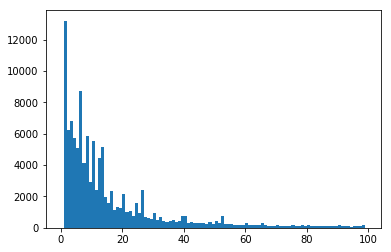

In [88]:
b = [i for i in range(0,100)]
plt.hist(seasonNum, bins = b)

plt.show() 

## Question 9 and 10

In [97]:
"""
IN this part I created input to take primaryName, birthyear, deathyear, and the tconst of the movie that they known
then update the name table with age and numtitles columns as well as knownfor table and nameprofession talbe
"""
def getInput():
    primaryName = input("primaryName: ")
    job = 'actor'
    
    while True:
        birth_year = input("birthYear(YYYY): ")

        if len(birth_year) == 0:
            birth_year = nan                    #NULL value in MySQL
            break
        try:
            birth_year = int(birth_year)
        except:
            print("Invalid year")
        if(birth_year <= datetime.date.today().year and birth_year > 1800):
            break
        print("Invalid year")


    while True:
        death_year = input("deathYear(YYYY): ")

        if len(death_year) == 0:
            death_year = nan                    #NULL value in MySQL
            break
        try:
            death_year = int(death_year)
        except:
            print("Invalid year")
        if(death_year < datetime.date.today().year and death_year > 0):
            break
        else:
            print("Invalid year")
    
    while True:
        titles_input = input("known for titleID: ")
        if len(titles_input) == 0:
            titleList = [nan]
            break
        titleList = titles_input.replace(' ', '').replace("'","").split(',').copy()
        
        #title_tconst is the list of primary key of the title table which was created above
        wrong_titleId = list(set(titleList) - set(title_tconst))
        if len(wrong_titleId) > 0:
            title_List = list(set(titleList) - set(wrong_titleId)).copy()
        break
    
    return primaryName, birth_year, death_year, job , titleList

def establish_connection(hostname, username, passcode, database_name):
    connection = None
    try:
        connection = mysql.connector.connect(host=hostname, user=username, passwd=passcode, database =database_name)
    except:
        print("Cannot connect MySQL server!")
    return connection

def execute_query(connection, query):
    cur = connection.cursor()
    try:
        cur.execute(query)
        connection.commit()
    except Error as err:
        print("Query error" + query)


def execute_multiple_queries(connection, sql, lst):
    cur = connection.cursor()
    try:
        cur.executemany(sql, lst)
        connection.commit()
    except Error as err:
        print("Multiple query")


def read_query(connection, query):
    cur = connection.cursor()
    result = None
    try:
        cur.execute(query)
        result = cur.fetchall()
        return result
    except Error as err:
        print("read_query error")


def addActor():
    # take and process user input
    newActor = getInput()
    
    # establish connection with server with the same password 
    connection = establish_connection("localhost", "root", password, 'mydb')

    # find the largest nconst
    maxNconst = "SELECT nconst FROM name ORDER BY nconst DESC LIMIT 1;"
    largestNconst = read_query(connection, maxNconst)
    lastNconstList = re.findall(r'(\w+?)(\d+)', largestNconst[0][0])
    print(lastNconstList)
    #re.findall(r"[^\W\d_]+|\d+",lastNconst)
    nconst = lastNconstList[0][0] + str(int(lastNconstList[0][1]) + 1)

    # insert values to name table 
    insertName_query = "INSERT INTO name(nconst, primaryName, birthYear, deathYear, age) VALUES(%s, %s, %s, %s,%s,%s);"
    name_values = [(nconst, newActor[0], newActor[1], newActor[2],newActor[2]-newActor[1],)]
    
    #execute the query from name_values input
    execute_multiple_queries(connection, insertName_query, name_values)
    
    # populate nameProfession table
    insertnameProfession_query = "INSERT INTO nameProfession(nconst, professionId) VALUES (%s, %s);"
    execute_multiple_queries(connection, insertnameProfession_query, [(nconst, 2)])
    
    update_age_query = "UPDATE name SET age = "

    addNewKnownFor = "INSERT INTO knownFor(tconst, nconst) VALUES ("
    for each in newActor[4]:
        print(addNewKnownFor + "'" + each + "', '" + nconst + "');")
        execute_query(connection, addNewKnownFor + "'" + each + "', '" + nconst + "');")

addActor()

primaryName: Doctor Strange
birthYear(YYYY): 1960 
deathYear(YYYY): 2017
known for titleID: tt0000002,tt0000003
[('nm', '9993720')]
Multiple query
Multiple query
INSERT INTO knownFor(tconst, nconst) VALUES ('tt0000002', 'nm9993721');
Query errorINSERT INTO knownFor(tconst, nconst) VALUES ('tt0000002', 'nm9993721');
INSERT INTO knownFor(tconst, nconst) VALUES ('tt0000003', 'nm9993721');
Query errorINSERT INTO knownFor(tconst, nconst) VALUES ('tt0000003', 'nm9993721');


## Question 11 
For this question, we defined a meanRating variable which holds the average of the averageRating column. This variable is used in the next cell to retrieve the names and ages of all actors who appeared in more than two movies with an above average rating (meanRating is used for this evaluation). 
We joined rating, title, format, knownFor, name and nameProfession tables because format contains information about whether a title is movie or not, rating contains information about the average rating for each title. KnownFor, name and nameProfession tables were joined to select actors.

In [15]:
engine.execute(" SET @meanRating  :=  (SELECT AVG(averageRating) FROM rating JOIN (title JOIN format USING(formatId)) USING(tconst));")

In [17]:
result = engine.execute("SELECT * FROM (SELECT nconst, primaryName,age, averageRating, description FROM ((rating JOIN (title JOIN format USING(formatId)) USING(tconst)) JOIN (knownFor JOIN name USING(nconst)) USING(tconst)) JOIN nameProfession USING(nconst) WHERE averageRating >= @meanRating AND description = 'movie' AND professionId = 2) AS qt GROUP BY nconst;")

result.fetchmany(size=10)

[('nm0836458', 'Lucia Sturza-Bulandra', 88, 7.5, 'movie'),
 ('nm1374534', 'Emilise Beretta', None, 7.1, 'movie'),
 ('nm0103130', 'Alma Bradley', None, 7.2, 'movie'),
 ('nm0564637', 'Elizabeth McCall', None, 7.2, 'movie'),
 ('nm0794096', 'Gertrude Shipman', None, 7.2, 'movie'),
 ('nm0029301', 'Yvette Andréyor', 71, 7.0, 'movie'),
 ('nm0137288', 'Renée Carl', 79, 7.0, 'movie'),
 ('nm0264491', 'Jane Faber', 88, 7.0, 'movie'),
 ('nm0096737', 'Hilda Borgström', 82, 7.1, 'movie'),
 ('nm1173967', 'Marie Dorly', None, 7.0, 'movie')]

## Question 12
The 1st image shows the time taken by a query with an index on primaryName column in name table. The 2nd image shows the time taken by a query without an index.
The code used to create the index was: engine.execute("""CREATE INDEX primaryName_idx ON Name (primaryName)""")
![image](files/q12_withIndex.png)
![image](files/q12_withoutIndex.jpg)